In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division
import six

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline
    
from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import (webbpsf, poppy, pix_noise, S)
pynrc.setup_logging('WARNING', verbose=False)

# Observation Definitions

In [3]:
def obs_wfe(wfe_drift, filt_list, sp_sci, dist, sp_ref=None):
    """
    For a given WFE drift and series of filters, create a list of 
    NIRCam observations. This function will calculate PSFs out to 10". 
    However, for the case of F200W+MASK335R, we will assume that the 
    subarray size matches that of a simultaneous LW observation (320x320).
    """
    if sp_ref is None:
        sp_ref = sp_sci
    
    filt_keys = []
    obs_dict = {}
    for filt, mask, pupil in filt_list:
        print(filt, mask, pupil)

        # Create identification keys
        if mask is None: mask = 'none'
        if pupil is None: pupil = 'none'
        key = '{}_{}_{}'.format(filt,mask,pupil)
        filt_keys.append(key)    

        # Set the PSF size and oversampling amount
        bp = pynrc.read_filter(filt)
        fov_pix = 640 if bp.avgwave()/1e4 < 2.5 else 320
        oversample = 2

        # Define the subarray readout size
        subsize = 640 if '210R' in mask else 320

        # Initialize and store the observation
        # A reference obseration is stored inside the parent obs_coronagraphy class.
        obs_dict[key] = pynrc.obs_coronagraphy(sp_sci, sp_ref, dist, wfe_drift=wfe_drift,
                                               filter=filt, mask=mask, pupil=pupil, 
                                               oversample=oversample, fov_pix=fov_pix,
                                               wind_mode='WINDOW', xpix=subsize, ypix=subsize)
    return obs_dict

In [4]:
def obs_optimize(obs_dict, sp_opt=None, tacq_max=1400, nint_min=15, ng_max=10, **kwargs):
    """
    Perform ramp optimization on each science and reference observation
    in a list of filter observations. Updates the detector MULTIACCUM
    settings for each observation in the dictionary.
    """

    # If sp_opt is not set, then default to a 20th magnitude flat source
    if sp_opt is None:
        bp_k = S.ObsBandpass('k')
        sp_opt = pynrc.stellar_spectrum('flat', 20, 'vegamag', bp_k)

    
    # Some observations may saturate, so define a list of  maximum well level
    # values that we will incrementally check until a ramp setting is found
    # that meets the contraints.
    well_levels = [0.8, 1.5, 2.0, 2.5, 3.0, 5.0, 10.0, 20.0, 100]
    # A very faint bg object on which to maximize S/N

   
    filt_keys = list(obs_dict.keys())
    filt_keys.sort()
    print(['Pattern', 'NGRP', 'NINT', 't_int', 't_exp', 't_acq', 'SNR', 'Well', 'eff'])
    for j, key in enumerate(filt_keys):
        print('')
        print(key)

        obs = obs_dict[key]
        sp_sci, sp_ref = (obs.sp_sci, obs.sp_ref)

        sci = obs
        ref = sci.nrc_ref
                
        # Ramp optimization for both science and reference targets
        for obs2, sp in zip([sci, ref], [sp_sci, sp_ref]):
            i = nrow = 0
            while nrow==0:
                well_max = well_levels[i]
                tbl = obs2.ramp_optimize(sp_opt, sp, tacq_max=tacq_max, tacq_frac=0.01, 
                                        nint_min=nint_min, ng_max=ng_max, 
                                        well_frac_max=well_max, ideal_Poisson=True,
                                        **kwargs)
                nrow = len(tbl)
                i+=1
                
            # Grab the highest ranked MULTIACCUM settings and update the detector readout
            v1, v2, v3 = tbl['Pattern', 'NGRP', 'NINT'][0]
            print(tbl[0].as_void())
            obs2.update_detectors(read_mode=v1, ngroup=v2, nint=v3)
        

# HR 8799 Contrast Comparisons

In [5]:
# Science Target
# Argument tuple: (Name, distance, sptype model params, age, kmag)
args_sci = ('HR 8799',   39.0, (7430, -0.47, 4.35),  100,  5.24)
name, dist, sp_args, age, kmag = args_sci

bp_k = S.ObsBandpass('k')
sp = S.Icat('ck04models', *sp_args)
sp_sci = sp.renorm(kmag, 'vegamag', bp_k)
sp_sci.name = name


# Reference Star
# Argument tuple: (Name, distance, sptype model params, age, kmag)
args_ref = ('HD 220657', 52.2, (5888, -0.01, 3.22), 1000,  3.04)
name_ref, dist_ref, sp_args, age_ref, kmag_ref = args_ref

sp = S.Icat('ck04models', *sp_args)
sp_ref = sp.renorm(kmag_ref, 'vegamag', bp_k)
sp_ref.name = name_ref

In [6]:
# HR8799 planet magnitudes
# [b, c, d, e]
planet_mags = {'F210M': np.array([17.0, 16.1, 16.1, 15.9]),
               'F200W': np.array([17.0, 16.1, 16.1, 15.9]),
               'F335M': np.array([16.2, 15.2, 15.0, 15.1]),
               'F356W': np.array([15.6, 14.7, 14.5, 14.6]),
               'F430M': np.array([15.8, 14.9, 14.5, 14.6]),
               'F444W': np.array([16.0, 15.0, 14.6, 14.7])}

# Locations
loc_xy = [(-1.57,  0.71), ( 0.52,  0.79), ( 0.39, -0.53), ( 0.38,  0.01)]
loc_rt = [(nrc_utils.xy_to_rtheta(x,y)) for x,y in loc_xy]
planet_dist = np.array([np.sqrt(x**2+y**2) for x,y in loc_xy])

## 1. Compare MASK335R vs. MASK430R

It might be worthwhile to always use the 335R circular mask instead of the 430R and 210R masks.
 1. Avoids overheads associated with switching between 430R and 335R
 2. Enables simulataneous SW/LW imaging
 
Here, we compare the resulting contrast curves for wide band filters paired with two mask options to test if MASK335R is an acceptable replacement.

In [10]:
# Generate and store contrast curves for each science and reference observation
rr_list       = [] # Radial distances
contrast_list = [] # Contrasts w.r.t. radial distance
magsens_list  = [] # Sensitivities w.r.t. radial distance

#filt_keys = obs_dict.keys()
#filt_keys.sort()
nsig = 5
roll_angle = 10
for key in filt_keys:
    print(key)
    obs = obs_dict[key]
    
    rr, contrast, magsens = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig)
    rr_list.append(rr)
    contrast_list.append(contrast)
    magsens_list.append(magsens)

F200W_MASK210R_CIRCLYOT
F200W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


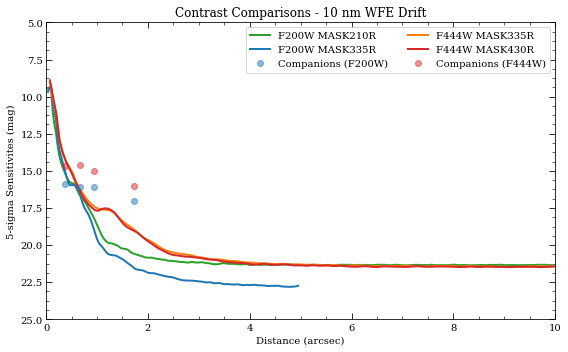

In [11]:
# Plot sensitivity curves along with location of companions
fig, ax = plt.subplots(figsize=(8,5))
colors = ['C2', 'C0', 'C1', 'C3']

for i, mag_sens in enumerate(magsens_list):
    rr = rr_list[i]
    filt, mask, pupil = args_list[i]
        
    # Plot contrast curves
    label="{} {}".format(filt,mask)
    ax.plot(rr, mag_sens, lw=2, label=label, color=colors[i])

    # Plot observed companion magnitudes
    pmag = planet_mags.get(filt)
    if i==1 or i==3:
        label = 'Companions ({})'.format(filt)
        ax.plot(planet_dist, pmag, marker='o', ls='None', label=label, 
                color=colors[i], alpha=0.5, zorder=10)
    
ax.legend(ncol=2)
ax.set_title('Contrast Comparisons - {} nm WFE Drift'.format(wfe_drift))
ax.set_xlabel('Distance (arcsec)')
ax.set_ylabel('{}-sigma Sensitivites (mag)'.format(nsig))
ax.set_xlim([0,10])
ax.set_ylim([25,5])
#ax.set_ylim([2e-9,2e-5])
ax.minorticks_on()

fig.tight_layout()

It appears that there isn't much of a trade-off between MASK335R and MASK430R with regards to F444W.

However, for F200W, you can get high sensitivity with MASK335R, because the mask blocks out more light so we don't saturate as quickly. Therefore, we are able to use more favorable MULTIACCUM ramps to reduce the read noise.

## 2. Create images

For a series of filters, generate some slope images.

In [7]:
# List of filters
args_list = [('F210M', 'MASK210R', 'CIRCLYOT'),
             ('F335M', 'MASK335R', 'CIRCLYOT'),
             ('F430M', 'MASK430R', 'CIRCLYOT')] 
#             ('F200W', 'MASK335R', 'CIRCLYOT'),
#             ('F356W', 'MASK335R', 'CIRCLYOT'), 
#             ('F444W', 'MASK335R', 'CIRCLYOT')]

filt_keys = []
for filt,mask,pupil in args_list:
    key = '{}_{}_{}'.format(filt,mask,pupil)
    filt_keys.append(key) 

In [8]:
# Create a list of observations of each filter
wfe_drift = 5
obs_dict = obs_wfe(wfe_drift, args_list, sp_sci, dist, sp_ref)

F210M MASK210R CIRCLYOT
F335M MASK335R CIRCLYOT
F430M MASK430R CIRCLYOT


In [9]:
for key in obs_dict:
    sci = obs_dict[key]
    ref = sci.nrc_ref
    sci.update_detectors(read_mode='MEDIUM8', ngroup=10, nint=15)
    ref.update_detectors(read_mode='MEDIUM8', ngroup=10, nint=15)

In [10]:
# For each obs configuration, add planet information
for k in filt_keys:
    obs = obs_dict[k]
    obs.kill_planets()
    mags = planet_mags[obs.filter]
    for loc, mag in zip(loc_rt, mags):
        renorm_args = (mag, 'vegamag', obs.bandpass)
        obs.add_planet(rtheta=loc, runits='asec', age=50, entropy=13, mass=10, renorm_args=renorm_args)
        
#    def add_planet(self, atmo='hy3s', mass=10, age=100, entropy=10,
#        rtheta=(0,0), runits='AU', Av=0, renorm_args=None, sptype=None,
#        accr=False, mmdot=None, mdot=None, accr_rin=2, truncated=False):


In [11]:
# Generate a list of roll-subtracted slope images, one for each filter
# PA rolls of 210 to 220 deg
final_hdus    = []
rr_list       = [] # Radial distances
contrast_list = [] # Contrasts w.r.t. radial distance
magsens_list  = [] # Sensitivities w.r.t. radial distance

PA1, PA2 = 210, 220
roll_angle = PA2 - PA1
nsig = 5
for k in filt_keys:
    print(k)
    obs = obs_dict[k]
    res = obs.gen_roll_image(PA1, PA2, oversample=2)
    final_hdus.append(res)

    # Generate and store contrast curves for each science and reference observation
    rr, contrast, magsens = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig)
    rr_list.append(rr)
    contrast_list.append(contrast)
    magsens_list.append(magsens)


F210M_MASK210R_CIRCLYOT
F335M_MASK335R_CIRCLYOT
F430M_MASK430R_CIRCLYOT


In [58]:
import os
def make_opd(base_opd, delta_opd, amplitude=1.0, verbose=True):
    opdf = fits.open(base_opd)
    deltaf = fits.open(delta_opd)

    delta = deltaf[0].data
    if verbose:
        print("Found a {} shape OPD".format(opdf[0].data.shape))
        print("Adding delta OPD from {} with scaling {}".format(delta_opd, amplitude))
    if len(opdf[0].data.shape) >2:
        for i in range(opdf[0].data.shape[0]):
            opdf[0].data[i] += delta*amplitude
            if verbose:
                print(" Adding to cube slice {}".format(i))
    else:
        opdf[0].data += delta*amplitude
        if verbose:
            print(" Adding to OPD.")
    opdf[0].header.add_history("Modified OPD by adding oscillation delta")
    opdf[0].header.add_history(" from "+delta_opd)
    opdf[0].header.add_history(" scaled by {}".format(amplitude)) 

    opdf[0].header['ORIGINAL'] = (os.path.basename(base_opd), 
                                         "Original file for this OPD")
    opdf[0].header['OFILE'] = (delta_opd, "Source file for oscillation OPD")
    opdf[0].header['OCASE'] = (deltaf[0].header['CASE'], "Oscillation model case")
    opdf[0].header['OVARIANT'] = (deltaf[0].header['VARIANT'],
                                         "Oscillation model variant")
    opdf[0].header['OAMP'] = (amplitude, "Oscillation model amplitude")
    
    return opdf

In [76]:
from pynrc import speckle_noise as sn

In [89]:
def make_opd_pair(dopd_hdul, wfe_drift=5):

    # Standard deviation for each pupil Zernike
    # Piston, Tip, Tilt, Focus, Astig, Coma, Trefoil,
    #   Spherical, 2nd Astig, and Quadrafoil
    pup_cf_std = np.array([ 0.0,  0.0,  0.0,  0.03258147,  0.02023745,
        0.02036721,  0.02493373,  0.02338593,  0.01750089,  0.00750398,
        0.01938736,  0.01712082,  0.01359327,  0.01458599,  0.00956585])
    seg_cf_std = np.array([ 0.0,  0.0,  0.0,  0.01140949,  0.01712216,
        0.01586312,  0.0234882 ,  0.02331315,  0.02316506,  0.02164931,
        0.02015695,  0.01749708,  0.01672629,  0.01263545,  0.01471005,
        0.0,  0.0,  0.0,  0.0,  0.0,
        0.0,  0.0,  0.0,  0.0,  0.0,
        0.0,  0.0,  0.0,  0.0,  0.0])

    opd_im = dopd_hdul[0].data[0]
    header = dopd_hdul[0].header
    
    # Create an object that extracts the Zernike components for the OPD file
    opd_obj = sn.OPD_extract(opd_im, header, seg_terms=5)
    
    # Generate science OPD image and residuals for use in reference drift.
    opd_orig, opd_resid = sn.opd_sci_gen(opd_obj)
    if wfe_drift > 0:
        # Generate reference OPD image
        args = (opd_obj, wfe_drift, pup_cf_std, seg_cf_std, opd_resid, 1)
        opd_drift = sn.opd_ref_gen(args)
        # Create OPD inside an HDUList to pass to WebbPSF
        hdu = fits.PrimaryHDU(opd_drift)
    else:
        hdu = fits.PrimaryHDU(opd_orig)

    hdu.header = header.copy()    
    return fits.HDUList([hdu])
    

In [69]:
webb_data_dir = pynrc.pynrc_core.webbpsf.utils.get_webbpsf_data_path() + '/'
opd_dir = webb_data_dir + 'NIRCam/OPD/'
base_opd = opd_dir + 'OPD_RevW_ote_for_NIRCam_requirements.fits'

# Get all delta OPD FITS file names
mod_dir = '/Volumes/NIRData/oscillation_opd_models/'
mod_files = []
for file in os.listdir(mod_dir):
    if file.endswith(".fits"):
        mod_files.append(file)
        
case_vals = np.array([np.int(mf.split('_')[2][4]) for mf in mod_files])
var_vals = np.array([np.int(mf.split('_')[3][3]) for mf in mod_files])

In [155]:
case, variant = (1,2)

ind = np.argwhere((case_vals==case) & (var_vals==variant)).flatten()[0]
delta_opd = mod_dir + mod_files[ind]

In [156]:
delta_rms_nom = 32.0
delta_rms = 10.0
amp = delta_rms / delta_rms_nom
dopd_hdul = make_opd(base_opd, delta_opd, amplitude=amp, verbose=False)

opd_ref = make_opd_pair(dopd_hdul, wfe_drift=5)

In [157]:
final_hdus2    = []
rr_list2       = [] # Radial distances
contrast_list2 = [] # Contrasts w.r.t. radial distance
magsens_list2  = [] # Sensitivities w.r.t. radial distance

PA1 = 210
PA2 = 220
roll_angle = PA2 - PA1
nsig = 5
for k in filt_keys:
    print(k)
    obs = obs_dict[k]
    obs.nrc_ref.update_psf_coeff(opd=opd_ref, force=True, save=False)
    
    res = obs.gen_roll_image(PA1, PA2, oversample=2)
    final_hdus2.append(res)

    # Generate and store contrast curves for each science and reference observation
    rr, contrast, magsens = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig)
    rr_list2.append(rr)
    contrast_list2.append(contrast)
    magsens_list2.append(magsens)

F210M_MASK210R_CIRCLYOT
F335M_MASK335R_CIRCLYOT
F430M_MASK430R_CIRCLYOT


In [90]:
delta_rms_nom = 32.0
delta_rms = 20.0
amp = delta_rms / delta_rms_nom
dopd_hdul = make_opd(base_opd, delta_opd, amplitude=amp, verbose=False)

opd_ref = make_opd_pair(dopd_hdul, wfe_drift=5)

In [91]:
final_hdus3    = []
rr_list3       = [] # Radial distances
contrast_list3 = [] # Contrasts w.r.t. radial distance
magsens_list3  = [] # Sensitivities w.r.t. radial distance

PA1 = 210
PA2 = 220
roll_angle = PA2 - PA1
nsig = 5
for k in filt_keys:
    print(k)
    obs = obs_dict[k]
    obs.nrc_ref.update_psf_coeff(opd=opd_ref, force=True, save=False)
    
    res = obs.gen_roll_image(PA1, PA2, oversample=2)
    final_hdus3.append(res)

    # Generate and store contrast curves for each science and reference observation
    rr, contrast, magsens = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig)
    rr_list3.append(rr)
    contrast_list3.append(contrast)
    magsens_list3.append(magsens)

F210M_MASK210R_CIRCLYOT
F335M_MASK335R_CIRCLYOT
F430M_MASK430R_CIRCLYOT


In [160]:
final_hdus_all    = final_hdus + final_hdus2 + final_hdus3
rr_list_all       = rr_list + rr_list2 + rr_list3
contrast_list_all = contrast_list + contrast_list2 + contrast_list3
magsens_list_all  = magsens_list + magsens_list2 + magsens_list3

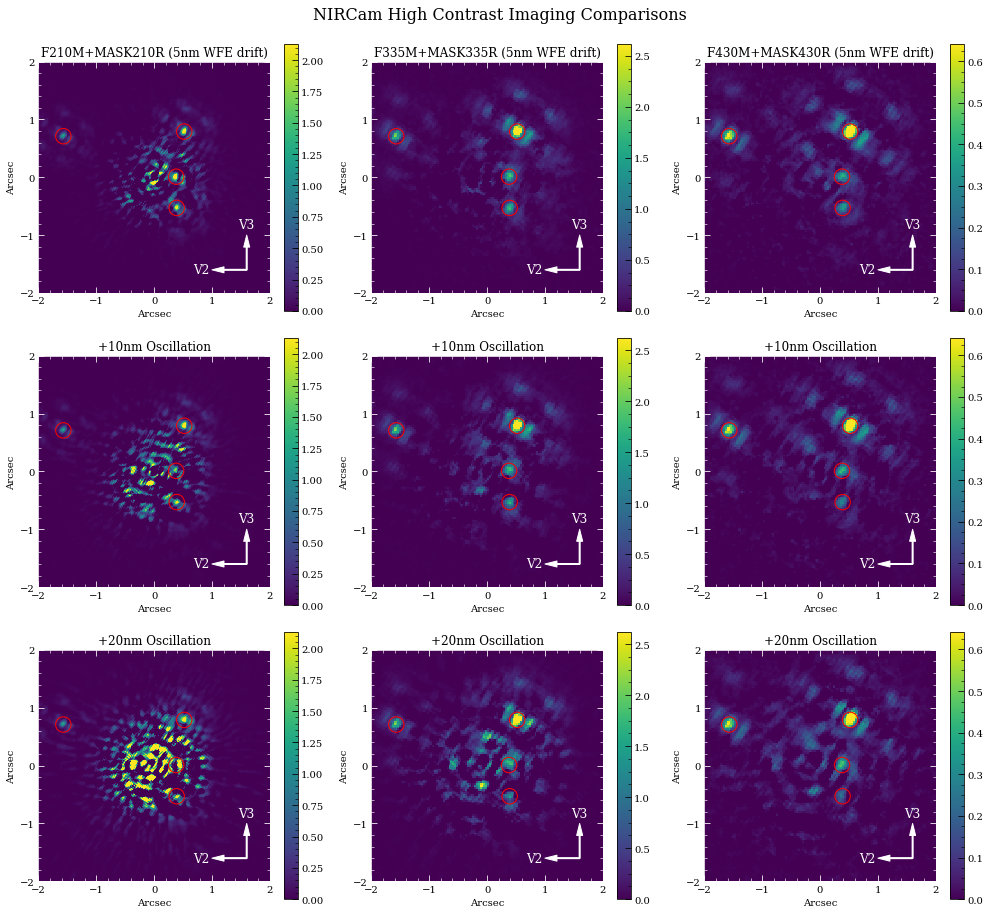

In [166]:
fig, axes = plt.subplots(3,3, figsize=(14,13))
#fig, axes = plt.subplots(1,3, figsize=(14,4))
axes = axes.flatten()

xylim = 2.0

#cmap = sns.cubehelix_palette(start=0, rot=0.5, light=1, as_cmap=True)
cmap = matplotlib.rcParams['image.cmap']
for i, ax in enumerate(axes):
    hdulist = final_hdus_all[i]
    data = hdulist[0].data
    
    # Nominal data settings for 
    ii = np.mod(i,3)
    data_nom = final_hdus_all[ii][0].data
    
    obs = obs_dict[filt_keys[ii]]
    
    vmax = data_nom.max() * 0.5
    #vmax = np.ceil(vmax)
    vmin = 0#np.min([0,data.min()])
    if i<3:
        title = '{}+{} (5nm WFE drift)'.format(obs.filter, obs.mask)
    elif i<6:
        title = '+10nm Oscillation'
    else:
        title = '+20nm Oscillation'
    
    ax, cb = webbpsf.display_psf(hdulist, ax=ax, title=title, colorbar=True, cmap=cmap, interpolation='nearest',
                                 scale='linear', vmin=vmin, vmax=vmax, imagecrop=5, return_ax=True)
    cb.set_label('')

    ax.set_xlim([-xylim,xylim])
    ax.set_ylim([-xylim,xylim])
    ax.set_xlabel('Arcsec')
    ax.set_ylabel('Arcsec')

    # Location of planet
    for pl in obs.planets:
        loc = np.array(pl['xyoff_pix']) * obs.pix_scale
        circle = matplotlib.patches.Circle(loc, radius=xylim/15., lw=1, edgecolor='red', facecolor='none')
        ax.add_artist(circle);

    nrc_utils.plotAxes(ax, width=1, headwidth=6, alength=0.15)
    
    ax.xaxis.get_major_locator().set_params(nbins=5, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=5, steps=[1, 2, 5, 10])

    #ax.axhline(0, ls=':', color='white', alpha=0.5, lw=3)
    #ax.axvline(0, ls=':', color='white', alpha=0.5, lw=3)

    ax.minorticks_on()
    ax.tick_params(axis='both', color='white', which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color('white')


fig.suptitle('NIRCam High Contrast Imaging Comparisons', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

fig.savefig('HR8799_lowamp_images.pdf')

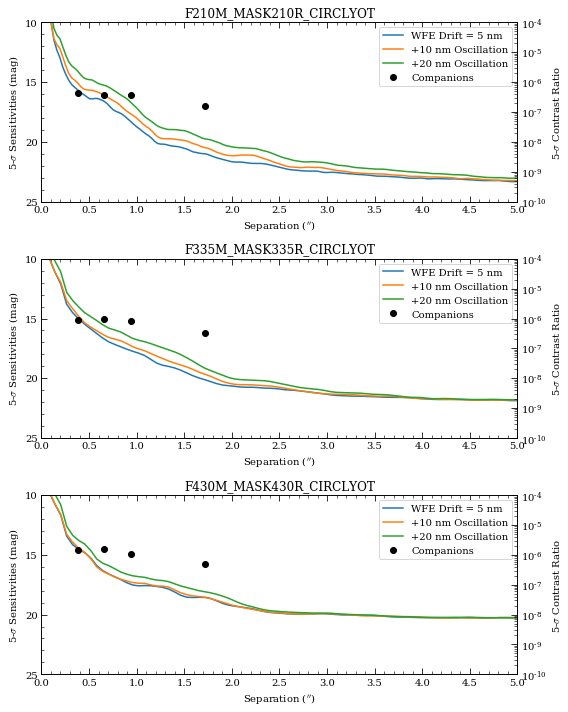

In [168]:
fig, axes = plt.subplots(3,1, figsize=(8,10))

ax = axes[0]
for i in range(len(rr_list_all)):
    rr       = rr_list_all[i]
    contrast = contrast_list_all[i]
    mag_sens = magsens_list_all[i]
    
    #if i==3: mag_sens[rr<2] = mag_sens[rr<2] - 0.2
    
    ii = np.mod(i,3)
    if i<3:
        label="WFE Drift = {} nm".format(wfe_drift)
    elif i<6:
        label="+10 nm Oscillation"
    else:
        label="+20 nm Oscillation"
    
    ax = axes[ii]
    ax.plot(rr, mag_sens, label=label)

for i, ax in enumerate(axes):
    filt, mask, pupil = args_list[i]
    pmag = planet_mags.get(filt)
    label = 'Companions'
    ax.plot(planet_dist, pmag, marker='o', ls='None', label=label, color='k', zorder=10)

    ax.set_xlim([0,5])
    ax.set_ylim([25,10])
    ax.minorticks_on()
    ax.set_title(filt_keys[i])
    ax.legend()
    
    ax.set_ylabel('{}-$\sigma$ Sensitivities (mag)'.format(nsig))
    ax.set_xlabel('Separation ($^{\prime\prime}$)')

    ax2 = ax.twinx()
    ax2.set_yscale("log")
    ymin2 = 10**(-ax.get_ylim()[0]/2.5)
    ymax2 = 10**(-ax.get_ylim()[1]/2.5)
    ax2.set_ylim([ymin2,ymax2])
    ax2.set_ylabel('{}-$\sigma$ Contrast Ratio'.format(nsig))
    
    ax.yaxis.get_major_locator().set_params(nbins=5, steps=[1, 2, 5, 10])
    ax.xaxis.get_major_locator().set_params(nbins=10, steps=[1, 2, 5, 10])
    
    
fig.tight_layout()
fig.savefig('HR8799_lowamp_contrast.pdf')

# Loss Grid

In [172]:
# Create nominal cases
for k in filt_keys:
    obs = obs_dict[k]
    obs._gen_ref()
#obs = obs_dict[filt_keys[0]]

In [176]:
mags = np.arange(0,12.5,0.5)

In [179]:
range(3500,12000,250)

range(3500, 12000, 250)

In [180]:
all_contrasts0 = {}
for k in filt_keys:
    print(k)
    obs = obs_dict[k]
    
    contrasts = []
    for mag in mags:
        bp = obs.bandpass
        sp = pynrc.stellar_spectrum('G2V', mag, 'vegamag', bp, catname='ck04models')
        obs.sp_sci = sp
        obs.sp_ref = sp
        
        contrasts.append(obs.calc_contrast(roll_angle=10, nsig=5))
        
    all_contrasts0[k] = contrasts

F210M_MASK210R_CIRCLYOT
F335M_MASK335R_CIRCLYOT
F430M_MASK430R_CIRCLYOT


In [181]:
delta_rms_nom = 32.0
delta_rms = 10.0
amp = delta_rms / delta_rms_nom
dopd_hdul = make_opd(base_opd, delta_opd, amplitude=amp, verbose=False)

opd_ref = make_opd_pair(dopd_hdul, wfe_drift=5)

In [182]:
all_contrasts2 = {}
for k in filt_keys:
    print(k)
    obs = obs_dict[k]
    obs.nrc_ref.update_psf_coeff(opd=opd_ref, force=True, save=False)
    
    contrasts = []
    for mag in mags:
        bp = obs.bandpass
        sp = pynrc.stellar_spectrum('G2V', mag, 'vegamag', bp, catname='ck04models')
        obs.sp_sci = sp
        obs.sp_ref = sp
        
        contrasts.append(obs.calc_contrast(roll_angle=10, nsig=5))
        
    all_contrasts2[k] = contrasts

F210M_MASK210R_CIRCLYOT
F335M_MASK335R_CIRCLYOT
F430M_MASK430R_CIRCLYOT


In [183]:
delta_rms_nom = 32.0
delta_rms = 20.0
amp = delta_rms / delta_rms_nom
dopd_hdul = make_opd(base_opd, delta_opd, amplitude=amp, verbose=False)

opd_ref = make_opd_pair(dopd_hdul, wfe_drift=5)

In [184]:
all_contrasts3 = {}
for k in filt_keys:
    print(k)
    obs = obs_dict[k]
    obs.nrc_ref.update_psf_coeff(opd=opd_ref, force=True, save=False)
    
    contrasts = []
    for mag in mags:
        bp = obs.bandpass
        sp = pynrc.stellar_spectrum('G2V', mag, 'vegamag', bp, catname='ck04models')
        obs.sp_sci = sp
        obs.sp_ref = sp
        
        contrasts.append(obs.calc_contrast(roll_angle=10, nsig=5))
        
    all_contrasts3[k] = contrasts

F210M_MASK210R_CIRCLYOT
F335M_MASK335R_CIRCLYOT
F430M_MASK430R_CIRCLYOT


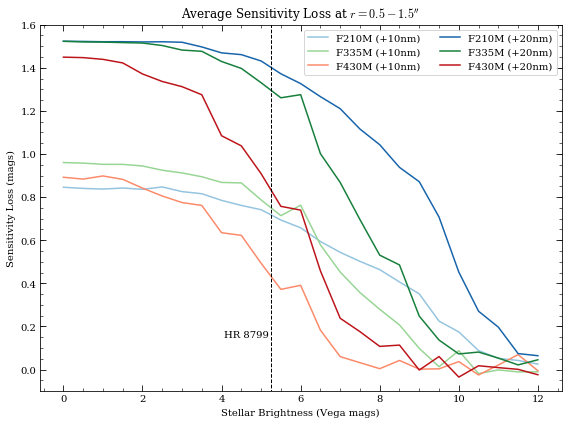

In [272]:
fig, ax = plt.subplots(1,1)

lin_vals = np.linspace(0.2,0.6,2)
colors1 = plt.cm.Blues_r(lin_vals)[::-1]
colors2 = plt.cm.Greens_r(lin_vals)[::-1]
colors3 = plt.cm.Reds_r(lin_vals)[::-1]

colors = [colors1[0], colors2[0], colors3[0]]
for j, k in enumerate(filt_keys):
    c0 = all_contrasts0[k]
    c2 = all_contrasts2[k]

    avgdiff2 = []
    for i in range(len(mags)):
        rr, contrast, magsens0 = c0[i]
        rr, contrast, magsens2 = c2[i]

        magdiff = magsens0 - magsens2
        avgdiff2.append(np.median(magdiff[(rr>0.5) & (rr<1.5)]))

    avgdiff2 = np.array(avgdiff2)
    
    obs = obs_dict[k]
    label = obs.filter + ' (+10nm)'
    
    ax.plot(mags, avgdiff2, color=colors[j], label=label)

colors = [colors1[1], colors2[1], colors3[1]]
for j, k in enumerate(filt_keys):
    c0 = all_contrasts0[k]
    c3 = all_contrasts3[k]

    avgdiff3 = []
    for i in range(len(mags)):
        rr, contrast, magsens0 = c0[i]
        rr, contrast, magsens3 = c3[i]

        magdiff = magsens0 - magsens3
        avgdiff3.append(np.median(magdiff[(rr>0.5) & (rr<1.5)]))

    avgdiff3 = np.array(avgdiff3)
    
    obs = obs_dict[k]
    label = obs.filter + ' (+20nm)'
    
    ax.plot(mags, avgdiff3, color=colors[j], label=label)


ax.plot([5.24,5.24], [-2,2], ls='--', color='k', lw=1)
ax.text(5.2,0.15,'HR 8799',horizontalalignment='right')
ax.set_ylim([-0.1, 1.6])

ax.set_title('Average Sensitivity Loss at $r=0.5-1.5^{{\prime\prime}}$')

ax.legend(ncol=2, loc=1)
ax.set_ylabel('Sensitivity Loss (mags)')
ax.set_xlabel('Stellar Brightness (Vega mags)')

#ax2 = ax.twinx()
#ax2.set_yscale("log")
#ymin2 = 10**(ax.get_ylim()[0]/2.5)
#ymax2 = 10**(ax.get_ylim()[1]/2.5)
#ax2.set_ylim([ymin2,ymax2])
#ax2.set_ylabel('Relative Loss Scale Factor')
#
#from matplotlib.ticker import FormatStrFormatter
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
#ax2.yaxis.set_minor_formatter(FormatStrFormatter('%.0f'))



fig.tight_layout()
fig.savefig('sensitivity_loss.pdf')

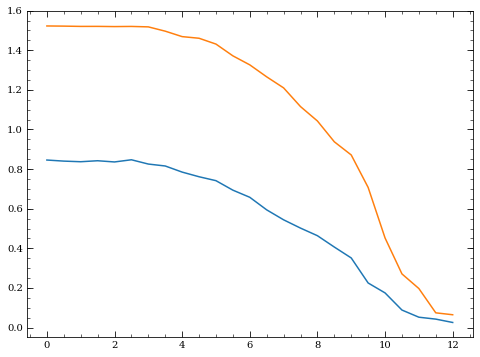

In [197]:

plt.plot(mags, avgdiff2)
plt.plot(mags, avgdiff3)

In [171]:
obs.psf_info

{'force': False,
 'fov_pix': 640,
 'jitter': None,
 'jitter_sigma': 0.007,
 'offset_r': 0,
 'offset_theta': 0,
 'opd': ('OPD_RevW_ote_for_NIRCam_requirements.fits', 0, 0),
 'oversample': 2,
 'save': True,
 'tel_pupil': None}